/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_64X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:01<00:00, 202MB/s] 


Epoch 1/15 - Train Acc: 0.9757, Val Acc: 0.9923
Epoch 2/15 - Train Acc: 0.9926, Val Acc: 0.9908
Epoch 3/15 - Train Acc: 0.9944, Val Acc: 0.9949
Epoch 4/15 - Train Acc: 0.9955, Val Acc: 0.9968
Epoch 5/15 - Train Acc: 0.9964, Val Acc: 0.9954
Epoch 6/15 - Train Acc: 0.9962, Val Acc: 0.9963
Epoch 7/15 - Train Acc: 0.9967, Val Acc: 0.9966
Epoch 8/15 - Train Acc: 0.9970, Val Acc: 0.9962
Epoch 9/15 - Train Acc: 0.9970, Val Acc: 0.9970
Epoch 10/15 - Train Acc: 0.9975, Val Acc: 0.9920
Epoch 11/15 - Train Acc: 0.9973, Val Acc: 0.9970
Epoch 12/15 - Train Acc: 0.9978, Val Acc: 0.9963
Epoch 13/15 - Train Acc: 0.9979, Val Acc: 0.9950
Epoch 14/15 - Train Acc: 0.9980, Val Acc: 0.9959
Epoch 15/15 - Train Acc: 0.9979, Val Acc: 0.9954


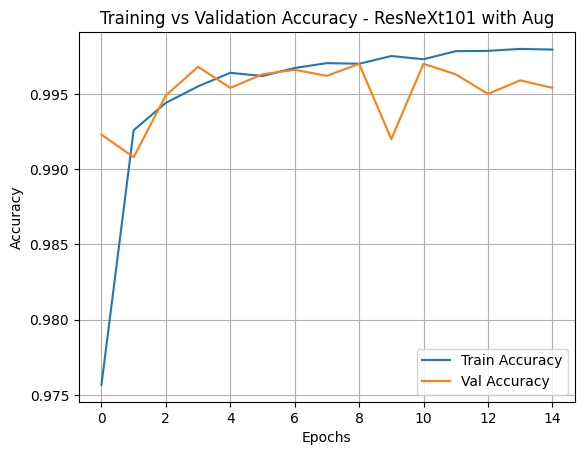


Classification Report RDIFF_ResNeXT101:

                    precision    recall  f1-score   support

       ANTHRACNOSE       1.00      0.99      0.99      1634
           DIEBACK       1.00      1.00      1.00      1664
   GALLMIDGEDAMAGE       0.99      1.00      0.99      1596
           HEALTHY       1.00      1.00      1.00      1793
INSECTDAMAGEWEBBER       1.00      0.99      0.99      1671
        LEAFBLIGHT       0.98      1.00      0.99      1643

          accuracy                           0.99     10001
         macro avg       0.99      0.99      0.99     10001
      weighted avg       0.99      0.99      0.99     10001



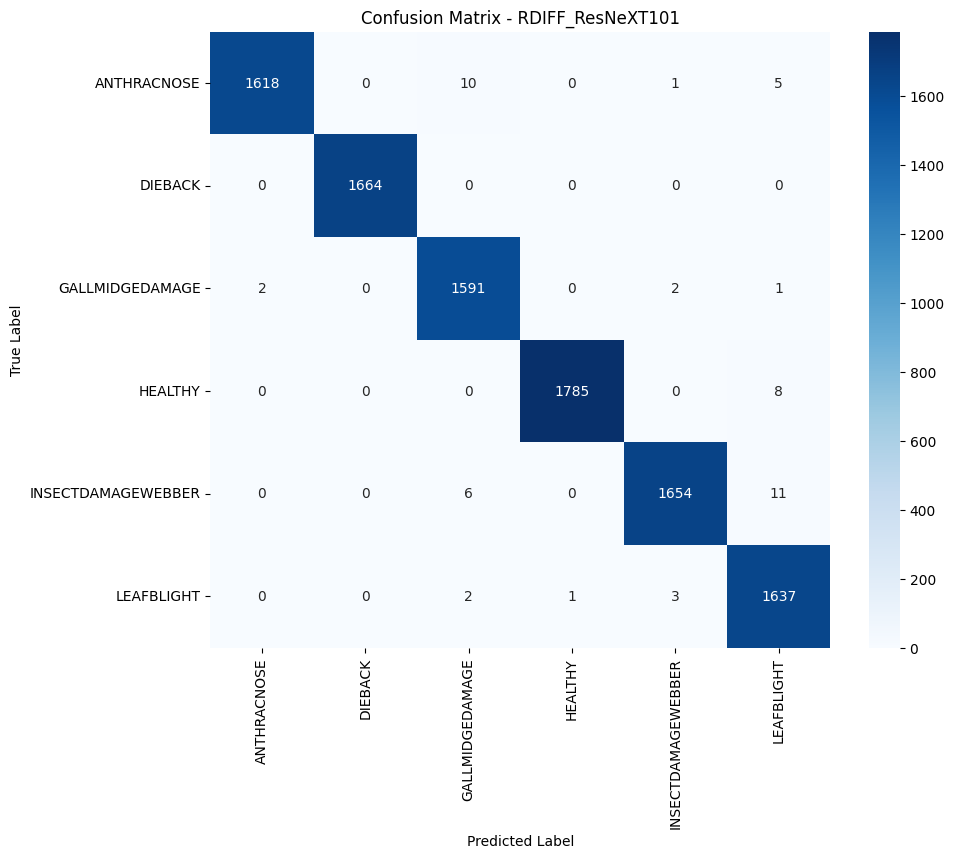

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths to your dataset
train_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/train'
val_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/val'
test_dir = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/test'

# Hyperparameters
BATCH_SIZE = 16
NUM_CLASSES = 6
NUM_EPOCHS = 15
LR = 1e-4

# Data transforms
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_test)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_test)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load pretrained ResNeXt101 model
model = models.resnext101_64x4d(pretrained=True)

# Replace the classifier
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, NUM_CLASSES)
)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
def train_model():
    history = {'train_acc': [], 'val_acc': []}
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_acc'].append(epoch_acc.item())

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / len(val_loader.dataset)
        history['val_acc'].append(val_acc.item())
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}")
    return history

history = train_model()

# Plot accuracy
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy - ResNeXt101 with Aug')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Classification report
class_names = test_dataset.classes
print("\nClassification Report RDIFF_ResNeXT101:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix - RDIFF_ResNeXT101")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()




In [3]:
# Compute test accuracy
correct = np.sum(np.array(y_true) == np.array(y_pred))
total = len(y_true)
test_accuracy = correct / total
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")



✅ Test Accuracy: 0.9948


In [4]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")

AttributeError: 'ResNet' object has no attribute 'evaluate'

In [6]:
# 📊 Visualize 50 random test samples per class using Grad-CAM and zip them

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import random
import zipfile
from tensorflow.keras.preprocessing import image

# ✅ Grad-CAM function
def get_gradcam_heatmap(model, image, class_index=None, last_conv_layer_name=None):
    if last_conv_layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_layer_name = layer.name
                break
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        if class_index is None:
            class_index = np.argmax(predictions[0])
        class_output = predictions[:, class_index]
    grads = tape.gradient(class_output, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# ✅ Heatmap overlay
def overlay_heatmap(heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    overlayed_img = cv2.addWeighted(image, 1 - alpha, heatmap_color, alpha, 0)
    return overlayed_img

# ✅ Save and zip folder
def zip_folder(folder_path, zip_name):
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

# ✅ Dataset path
test_path = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/test'
class_labels = list(train_generator.class_indices.keys())
save_dir = "gradcam_outputs"
os.makedirs(save_dir, exist_ok=True)

# ✅ Loop through each class and pick 50 random images
for cls in class_labels:
    class_dir = os.path.join(test_path, cls)
    image_files = os.listdir(class_dir)
    random_images = random.sample(image_files, min(50, len(image_files)))

    print(f"\n📌 Visualizing 50 Grad-CAM samples for class: {cls}")
    plt.figure(figsize=(20, 20))

    for i, img_name in enumerate(random_images):
        img_path = os.path.join(class_dir, img_name)

        # Load and preprocess
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        heatmap = get_gradcam_heatmap(model, img_array)
        original = (img_array * 255).astype(np.uint8)
        overlay = overlay_heatmap(heatmap, original)

        # Save image
        filename = f"{cls}_{img_name.split('.')[0]}_gradcam.jpg"
        cv2.imwrite(os.path.join(save_dir, filename), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))

        # Plot only first 10
        if i < 10:
            plt.subplot(2, 5, i + 1)
            plt.imshow(overlay)
            plt.title(f"{cls}\n{img_name}", fontsize=9)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# ✅ Zip all saved Grad-CAM images
zip_folder(save_dir, "gradcam_samples.zip")
print("✅ Zipped Grad-CAM samples to gradcam_samples.zip")


2025-07-14 20:56:51.977158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752526612.307728      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752526612.411649      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


NameError: name 'train_generator' is not defined

In [7]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from PIL import Image
import cv2
import numpy as np
import os, random, zipfile
from tqdm import tqdm

# ✅ Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_path = '/kaggle/input/diffmango224x224/AMBADIFUSEDATASET224X224/test'
output_dir = '/kaggle/working/gradcam_outputs'
os.makedirs(output_dir, exist_ok=True)

# ✅ Load model with same structure
model = models.resnext101_64x4d(pretrained=True)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(512, 6)
)
model.to(device)
model.eval()

# ✅ Grad-CAM generator
def get_gradcam(model, input_tensor, class_idx, target_layer):
    activations, gradients = [], []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_backward_hook(backward_hook)

    model.zero_grad()
    output = model(input_tensor)
    class_score = output[0, class_idx]
    class_score.backward()

    grads = gradients[0][0]
    acts = activations[0][0]
    pooled_grads = torch.mean(grads, dim=(1, 2))
    for i in range(acts.shape[0]):
        acts[i] *= pooled_grads[i]
    heatmap = torch.mean(acts, dim=0).cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap) if np.max(heatmap) != 0 else heatmap

    handle_f.remove()
    handle_b.remove()
    return heatmap

# ✅ Overlay
def overlay_heatmap(img, heatmap):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    cmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    return cv2.addWeighted(img, 0.6, cmap, 0.4, 0)

# ✅ Transform (no normalization for raw image)
transform_input = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ✅ Target layer
target_layer = model.layer4[-1]

# ✅ Process each class
for cls in os.listdir(test_path):
    cls_dir = os.path.join(test_path, cls)
    if not os.path.isdir(cls_dir): continue
    images = os.listdir(cls_dir)
    random.shuffle(images)

    save_cls_dir = os.path.join(output_dir, cls)
    os.makedirs(save_cls_dir, exist_ok=True)

    count = 0
    for img_name in images:
        if count >= 50: break
        try:
            img_path = os.path.join(cls_dir, img_name)
            pil_img = Image.open(img_path).convert('RGB')
            input_tensor = transform_input(pil_img).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(input_tensor)
                class_idx = torch.argmax(output[0]).item()

            heatmap = get_gradcam(model, input_tensor, class_idx, target_layer)

            # Convert original to OpenCV format
            raw_img = np.array(pil_img.resize((224, 224)))
            overlay = overlay_heatmap(raw_img, heatmap)
            save_path = os.path.join(save_cls_dir, f"{count:03d}_{cls}.jpg")
            cv2.imwrite(save_path, overlay[:, :, ::-1])  # RGB → BGR
            count += 1
        except Exception as e:
            print(f"❌ {img_name}: {e}")
            continue

# ✅ Zip folder
zip_path = '/kaggle/working/gradcam_outputs.zip'
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for root, _, files in os.walk(output_dir):
        for file in files:
            full_path = os.path.join(root, file)
            rel_path = os.path.relpath(full_path, output_dir)
            zipf.write(full_path, arcname=rel_path)

print(f"✅ ZIP created: {zip_path}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_64X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_f

✅ ZIP created: /kaggle/working/gradcam_outputs.zip


In [5]:
import torch
import os
import shutil

# 📂 Directory to save model files
save_dir = '/kaggle/working/saved_models'
os.makedirs(save_dir, exist_ok=True)

# 🧠 Assuming 'model' is your trained PyTorch model (e.g., torchvision.models.densenet201)
# Example: model = torchvision.models.densenet201(pretrained=False)

# 1️⃣ Save the full model
full_model_path = os.path.join(save_dir, 'RDIFF_ResNeXT101_full.pth')
torch.save(model, full_model_path)

# 2️⃣ Save only the model weights (state_dict)
weights_path = os.path.join(save_dir, 'RDIFF_ResNeXT101_weights.pth')
torch.save(model.state_dict(), weights_path)

# 📦 Zip the saved_models directory
zip_output_path = '/kaggle/working/mango_models_RDIFF_ResNeXT101'
shutil.make_archive(zip_output_path, 'zip', save_dir)

print(f"\n✅ Model saved successfully:")
print(f"   - Full model: {full_model_path}")
print(f"   - Weights only: {weights_path}")
print(f"   - Zipped: {zip_output_path}.zip")


✅ Model saved successfully:
   - Full model: /kaggle/working/saved_models/RDIFF_ResNeXT101_full.pth
   - Weights only: /kaggle/working/saved_models/RDIFF_ResNeXT101_weights.pth
   - Zipped: /kaggle/working/mango_models_RDIFF_ResNeXT101.zip
